# AMOC variability in cold vs warm phases

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.signal import welch

In [5]:
from dask.distributed import Client, LocalCluster, wait

In [6]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39497 instead
  expected, actual


In [7]:
client

Client Scheduler: tcp://127.0.0.1:44545 Dashboard: http://127.0.0.1:39497/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [8]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

## Read NEMO mesh

In [9]:
# NEMO mesh
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)

## Read NEMO stream functions

In [10]:
exp_list = ['FOCI_GJK001','FOCI_GJK001']
label_list = ['Warm phase','Cold phase']
time_list = [slice('2200-01-01','2400-01-01'), slice('2600-01-01','2800-01-01')]

In [11]:
# NEMO derived
ds_moc_all = []
ds_psi_all = []
for exp,time in zip(exp_list,time_list):
    moc = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*MOC.nc' % (esmdir,exp,exp)
    print(moc)
    ds_moc = xr.open_mfdataset(moc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_moc_all.append(ds_moc)
    
    psi = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*PSI.nc' % (esmdir,exp,exp)
    print(psi)
    ds_psi = xr.open_mfdataset(psi,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_psi_all.append(ds_psi)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*MOC.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*PSI.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*MOC.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*PSI.nc


In [16]:
ds_moc

<xarray.Dataset>
Dimensions:    (depthw: 46, time: 2400, x: 1, y: 511)
Coordinates:
  * depthw     (depthw) float32 -0.0 -6.194 -12.84 ... -5.5e+03 -5.75e+03
  * time       (time) object 2600-01-16 12:00:00 ... 2799-12-16 12:00:00
Dimensions without coordinates: x, y
Data variables:
    nav_lon    (time, y, x) float32 dask.array<chunksize=(120, 511, 1), meta=np.ndarray>
    nav_lat    (time, y, x) float32 dask.array<chunksize=(120, 511, 1), meta=np.ndarray>
    zomsfglo   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfatl   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfinp   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfind   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfpac   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfinp0  (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           Partial step computation

## Differences in time mean

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:975: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:975: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:975: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive =

AMOC taken at latitude: 60.100319


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  .format(nperseg, input_length))
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  .format(nperseg, input_length))


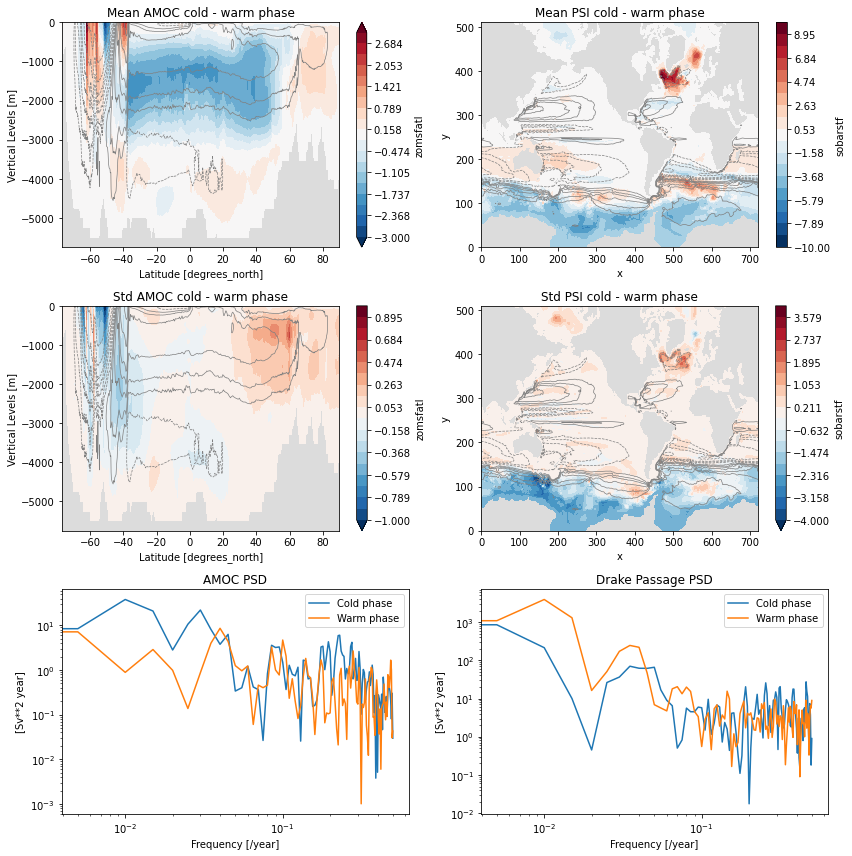

In [18]:
fig, ax = plt.subplots(3,2,figsize=(12,12))
bg_color = 'Gainsboro'

i1 = 1
i2 = 0

amoc1 = ds_moc_all[i1]['zomsfatl'].sel(x=0).groupby('time.year').mean('time').compute()
amoc2 = ds_moc_all[i2]['zomsfatl'].sel(x=0).groupby('time.year').mean('time').compute()
amoc_lat = ds_moc['nav_lat'].isel(time=0,x=0)
amoc1 = amoc1.where(amoc1 != 0).assign_coords(y=amoc_lat)
amoc2 = amoc2.where(amoc2 != 0).assign_coords(y=amoc_lat)

baro1 = ds_psi_all[i1]['sobarstf'].groupby('time.year').mean('time').compute() * 1e-6
baro2 = ds_psi_all[i2]['sobarstf'].groupby('time.year').mean('time').compute() * 1e-6

amoc_diff = amoc1.mean('year') - amoc2.mean('year')
baro_diff = baro1.mean('year') - baro2.mean('year')

#mlevels = np.linspace(-20,20,10)
mlevels = np.array([-50,-30,-20,-15,-10,-5,-2,2,5,10,15,20,30,50])
mlevels2 = np.linspace(-3,3,20)
amoc_diff.plot.contourf(ax=ax[0,0],levels=mlevels2,rasterized=True)
amoc1.mean('year').plot.contour(ax=ax[0,0],colors='gray',levels=mlevels,linewidths=0.7)
ax[0,0].set_title('Mean AMOC cold - warm phase')
ax[0,0].set_facecolor(bg_color)

mlevels2 = np.linspace(-1,1,20)
(amoc1.std('year') - amoc2.std('year')).plot.contourf(ax=ax[1,0],levels=mlevels2,rasterized=True)
amoc1.mean('year').plot.contour(ax=ax[1,0],colors='gray',levels=mlevels,linewidths=0.7)
ax[1,0].set_title('Std AMOC cold - warm phase')
ax[1,0].set_facecolor(bg_color)

#mlevels = np.linspace(-150,150,20)
mlevels = np.array([-150,-100,-80,-50,-30,-20,-10,10,20,30,50,80,100,150])
mlevels2 = np.linspace(-10,10,20)
baro_diff.where(da_orca05_mask > 0).plot.contourf(ax=ax[0,1],levels=mlevels2,rasterized=True)
baro1.mean('year').where(da_orca05_mask > 0).plot.contour(ax=ax[0,1],colors='gray',levels=mlevels,linewidths=0.7)
ax[0,1].set_title('Mean PSI cold - warm phase')
ax[0,1].set_facecolor(bg_color)

mlevels2 = np.linspace(-4,4,20)
(baro1.std('year') - baro2.std('year')).where(da_orca05_mask > 0).plot.contourf(ax=ax[1,1],levels=mlevels2,rasterized=True)
baro1.mean('year').where(da_orca05_mask > 0).plot.contour(ax=ax[1,1],colors='gray',levels=mlevels,linewidths=0.7)
ax[1,1].set_title('Std PSI cold - warm phase')
ax[1,1].set_facecolor(bg_color)

# Power spectra
#y_amoc = 304 # 26.5N
y_amoc = 394 # 60N
amoc_lat = ds_moc_all[i1]['nav_lat'][0,y_amoc,0]
print('AMOC taken at latitude: %f' % (amoc_lat,))
amoc_max1 = amoc1.isel(y=y_amoc).max('depthw').compute()
amoc_max2 = amoc2.isel(y=y_amoc).max('depthw').compute()
drake1 = (baro1.sel(x=436,y=51) - baro1.sel(x=436,y=119)).compute()
drake2 = (baro2.sel(x=436,y=51) - baro2.sel(x=436,y=119)).compute()

freq1, amoc_psd1 = welch(amoc_max1,fs=1)
freq2, amoc_psd2 = welch(amoc_max2,fs=1)

ax[2,0].loglog(freq1,amoc_psd1,label='%s' % (label_list[i1],))
ax[2,0].loglog(freq2,amoc_psd2,label='%s' % (label_list[i2],))
ax[2,0].set_xlabel('Frequency [/year]');
ax[2,0].set_ylabel('[Sv**2 year]');
ax[2,0].set_title('AMOC PSD');
ax[2,0].legend()

freq1, drake_psd1 = welch(drake1,fs=1)
freq2, drake_psd2 = welch(drake2,fs=1)

ax[2,1].loglog(freq1,drake_psd1,label='%s' % (label_list[i1],))
ax[2,1].loglog(freq2,drake_psd2,label='%s' % (label_list[i2],))
ax[2,1].set_xlabel('Frequency [/year]');
ax[2,1].set_ylabel('[Sv**2 year]');
ax[2,1].set_title('Drake Passage PSD');
ax[2,1].legend()

fig.tight_layout()
fig.savefig('Fig6_PSD_cold_vs_warm.pdf',format='pdf')

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:975: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)


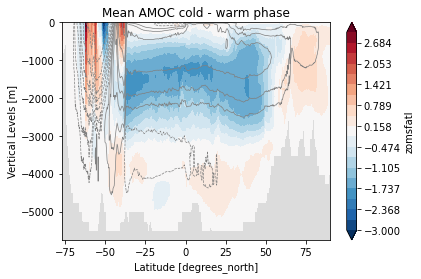

In [13]:
fig, ax = plt.subplots(1,1)

mlevels = np.array([-50,-30,-20,-15,-10,-5,-2,2,5,10,15,20,30,50])
mlevels2 = np.linspace(-3,3,20)
amoc_diff.plot.contourf(ax=ax,levels=mlevels2,rasterized=True)
amoc1.mean('year').plot.contour(ax=ax,colors='gray',levels=mlevels,linewidths=0.7)
ax.set_title('Mean AMOC cold - warm phase')
ax.set_facecolor(bg_color)

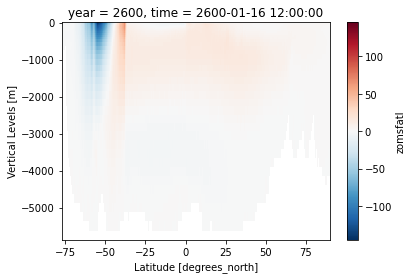

In [14]:

z = amoc1.where(amoc1 != 0).sortby('y')
z[0,:,:].plot()